In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

# Process the pdb file and summarize overall results to csv file

In [3]:
output_dir = "generation-results/dplm_650m"

plddt_dict = {
    'seq_idx': [],
    'length': [],
    'plddt': []
}

for pdb_foldername in os.listdir(os.path.join(output_dir, 'esmfold_pdb')):
    length = pdb_foldername.split('_')[3]
    for pdb_filename in os.listdir(os.path.join(output_dir, f'esmfold_pdb/{pdb_foldername}')):
        seq_idx = pdb_filename.split('_')[1]
        plddt = pdb_filename.split('_')[-1][:-4]
        plddt_dict['seq_idx'].append(int(seq_idx))
        plddt_dict['length'].append(int(length))
        plddt_dict['plddt'].append(float(plddt))
    
plddt_df = pd.DataFrame(plddt_dict).sort_values('length')
plddt_df = plddt_df.groupby('length', group_keys=False).apply(lambda x: x.sort_values('seq_idx'))
plddt_df.to_csv(os.path.join(output_dir, 'result.csv'))
plddt_df

    

/tmp/ipykernel_10800/1838829422.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plddt_df = plddt_df.groupby('length', group_keys=False).apply(lambda x: x.sort_values('seq_idx'))


,seq_idx,length,plddt
0,0,100,73.436035
11,1,100,85.358810
22,2,100,47.136200
33,3,100,43.678627
34,4,100,74.624428
...,...,...,...
188,35,500,94.508049
189,36,500,91.406937
190,37,500,82.436523
191,38,500,87.450317


# Lineplot according to the sequence length

In [4]:
output_dir_list = ["generation-results/dplm_650m/result.csv"]
model_name_list = ['dplm_650m']
plddt_df_list = []
for i, output_dir in enumerate(output_dir_list):
    plddt_df = pd.read_csv(output_dir)
    plddt_df = plddt_df.groupby('length', as_index=False)['plddt'].mean()
    plddt_df['model'] = model_name_list[i]
    plddt_df_list.append(plddt_df)
plddt_df = pd.concat(plddt_df_list, ignore_index=True)
plddt_df

,length,plddt,model
0,100,70.241217,dplm_650m
1,200,83.125927,dplm_650m
2,300,85.899873,dplm_650m
3,400,84.032781,dplm_650m
4,500,83.599222,dplm_650m


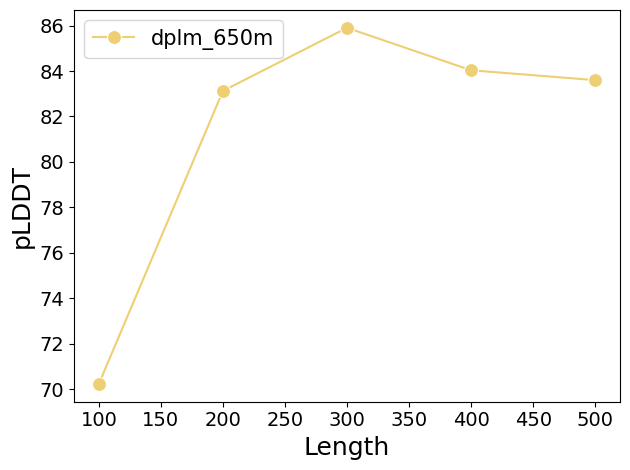

In [5]:
# Create scatter plot
palette_candidate = ['#EECF73', '#5FB1A5', '#F9633D']
palette = [palette_candidate[i] for i in range(len(model_name_list))]
markers_candidate = ['o', 'v', 's']
markers = [markers_candidate[i] for i in range(len(model_name_list))]
# palette = ['#8dd3c7', '#80b1d3', '#bebada']
sns.lineplot(data=plddt_df, x='length', y='plddt', hue='model', style='model', markers=markers,
             markersize=10, dashes=False, palette=palette)

# Adding labels and title
plt.xlabel('Length', fontdict={'size': 18})
plt.ylabel('pLDDT', fontdict={'size': 18})
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()
plt.legend(title=None, prop={'size': 15})

# Show plot
plt.show()

# Diversity Analysis

In [29]:
df_length = []
def load_tmscore(eval_dir):
    dfs = []
    for path in glob.glob(eval_dir + "/**/inter_tmscore.csv"):
        print(path)
        df = pd.read_csv(path)
        length = path.split('/')[-2].split('_')[-1]
        df['length'] = [length] * len(df)
        dfs.append(df)
    df_cat = pd.concat(dfs)
    df_cat = df_cat.sort_values("length")
    return df_cat

../generation-results/dplm_650m/diversity/iter_500_L_100/inter_tmscore.csv
../generation-results/dplm_650m/diversity/iter_500_L_200/inter_tmscore.csv
../generation-results/dplm_650m/diversity/iter_500_L_300/inter_tmscore.csv
../generation-results/dplm_650m/diversity/iter_500_L_400/inter_tmscore.csv
../generation-results/dplm_650m/diversity/iter_500_L_500/inter_tmscore.csv


/tmp/ipykernel_13209/836779224.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_cat.groupby('length').apply(lambda x: x['tm_scores_mean'].mean())
/tmp/ipykernel_13209/836779224.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='length', y='inner-TM', data=df, palette="Spectral", edgecolor="black")


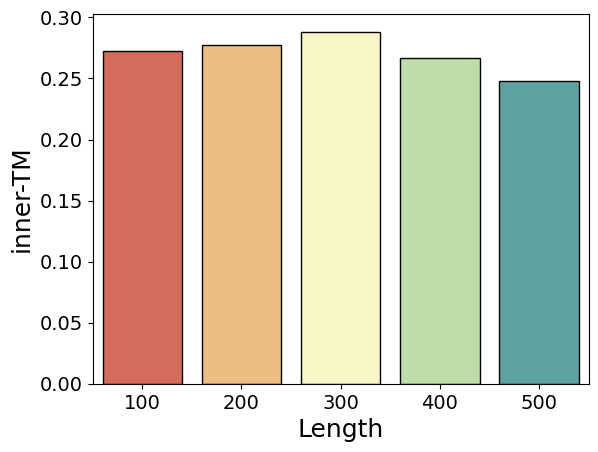

In [31]:
dir_path = "../generation-results/dplm_650m/diversity"
df_cat = load_tmscore(dir_path)
df_cat['tm_scores'] = df_cat['tm_scores'].apply(lambda x: eval(x))
df_cat['tm_scores_mean'] = df_cat['tm_scores'].apply(lambda x: sum(x)/len(x))

df = df_cat.groupby('length').apply(lambda x: x['tm_scores_mean'].mean())
df = df.reset_index()
df.columns = ['length', 'inner-TM']
# plt.figure(figsize=(10, 6))
sns.barplot(x='length', y='inner-TM', data=df, palette="Spectral", edgecolor="black")
plt.xlabel('Length', fontdict={'size': 18})
plt.ylabel('inner-TM', fontdict={'size': 18})
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

# Novelty Analysis

In [21]:
df_length = []
def load_tmscore(eval_dir):
    dfs = []
    for path in glob.glob(eval_dir + "/**/inter_tmscore.csv"):
        print(path)
        df = pd.read_csv(path)
        length = path.split('/')[-2].split('_')[-1]
        df['length'] = [length] * len(df)
        dfs.append(df)
    df_cat = pd.concat(dfs)
    df_cat = df_cat.sort_values("length")
    return df_cat

../generation-results/dplm_650m/novelty/iter_500_L_100/inter_tmscore.csv
../generation-results/dplm_650m/novelty/iter_500_L_200/inter_tmscore.csv
../generation-results/dplm_650m/novelty/iter_500_L_300/inter_tmscore.csv
../generation-results/dplm_650m/novelty/iter_500_L_400/inter_tmscore.csv
../generation-results/dplm_650m/novelty/iter_500_L_500/inter_tmscore.csv


/tmp/ipykernel_13209/297249591.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_cat.groupby('length').apply(lambda x: x['tm_scores_max'].mean())
/tmp/ipykernel_13209/297249591.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='length', y='pdb-TM', data=df, palette="Spectral", edgecolor="black")


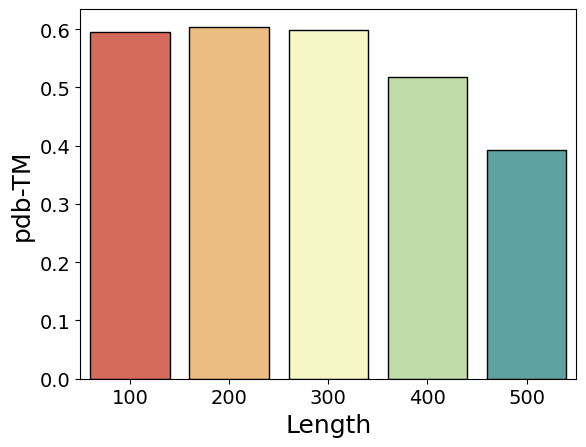

In [32]:
dir_path = "../generation-results/dplm_650m/novelty"
df_cat = load_tmscore(dir_path)
df_cat['tm_scores'] = df_cat['tm_scores'].apply(lambda x: eval(x))
df_cat['tm_scores_max'] = df_cat['tm_scores'].apply(lambda x: max(x))

df = df_cat.groupby('length').apply(lambda x: x['tm_scores_max'].mean())
df = df.reset_index()
df.columns = ['length', 'pdb-TM']
# plt.figure(figsize=(10, 6))
sns.barplot(x='length', y='pdb-TM', data=df, palette="Spectral", edgecolor="black")
plt.xlabel('Length', fontdict={'size': 18})
plt.ylabel('pdb-TM', fontdict={'size': 18})
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()